<a href="https://colab.research.google.com/github/nbPittigiani/sna-facebook-ego-network/blob/main/Social_Network_Analysis_facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resumo**

Neste projeto, foi analisada uma rede social do Facebook para identificar sua estrutura comunitária. Utilizando o algoritmo Louvain, foram detectadas 16 comunidades coesas, uma escolha justificada por uma alta modularidade. A eficácia do algoritmo foi validada com sucesso contra os dados reais (NMI de 0.71), e a estrutura final foi visualizada no Gephi, confirmando a organização da rede em grandes 'círculos sociais' conectados por hubs influentes.

---

# **1. Introdução**

> A Análise de Redes Sociais (SNA) é uma disciplina poderosa que utiliza a teoria dos grafos para estudar as relações e os fluxos entre entidades. Sua importância transcende a análise de amizades online, gerando impacto em diversas áreas: desde a **identificação de influenciadores** em campanhas de marketing e a **detecção de anéis de fraude financeira**, até o **mapeamento da disseminação de doenças** em epidemiologia e a **otimização da comunicação** em grandes corporações. Em sua essência, a SNA nos fornece um mapa para navegar na complexidade das conexões que governam o mundo.

Um dos problemas centrais da SNA é a detecção automática de comunidades — grupos coesos que se formam naturalmente dentro das redes. Identificar esses "círculos sociais" nos permite entender a organização, a dinâmica e os pontos de vulnerabilidade de qualquer sistema conectado.

## **1.1. Conceitos Fundamentais**

Para navegar neste estudo, é essencial compreender três conceitos básicos que formam a base de qualquer rede:

* **Nós (nodes):** Representa uma entidade individual na rede. Neste projeto, cada nó é uma pessoa (um usuário do Facebook).
* **Arestas (Edges):** Representa a conexão entre dois nós. Aqui, uma aresta significa uma amizade na rede social.
* **Comunidade:** Um conjunto de nós que estão muito mais densamente conectados entre si do que com o restante da rede. São os "grupos" que emergem naturalmente da estrutura de conexões.

## **1.2. Objetivo Geral**

Este notebook documenta um estudo prático focado na aplicação e validação de algoritmos para particionar os **nós** de uma rede em **comunidades**, com base na topologia de suas **arestas**. O projeto serve como um roteiro de aprendizado, aplicando os conceitos fundamentais da SNA a um dataset do mundo real para construir um entendimento sólido e prático na área.

## **1.3. Objetivos Específicos**

* Aplicar os principais conceitos de SNA estudados — como análise de centralidade e detecção de comunidades.
* Avaliar e comparar a performance e os resultados de diferentes algoritros de detecção de comunidades, utilizando a métrica de modularidade e a estrutura de "círculos" reais do dataset como critérios.

## **1.4. Dataset**

A análise é realizada sobre o dataset "Social circles: Facebook", disponibilizado pelo Stanford Network Analysis Project (SNAP). A rede é composta por 4.039 usuários (nós) e 88.234 relações de amizade (arestas), formando um grafo não-direcionado e conectado.


## **1.5. Metodologia**

* Análise Exploratória
* Análise de Centralidade
* Detecção e Comparação de Comunidades
* Análise e Validação

---

# **2. Análise Exploratória de Dados (EDA)**

A primeira etapa do projeto consiste na Análise Exploratória de Dados (EDA), onde o dataset é carregado, validado e suas principais características estruturais são investigadas. O objetivo é <b>obter uma compreensão fundamental da topologia da rede</b> antes de aplicar algoritmos mais complexos.


In [1]:
# Installar bibliotecas necessárias
!pip install python-igraph pycairo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.1 MB/s eta 0:00:00


In [32]:
import pandas as pd
import numpy as np
from igraph import Graph, plot
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Union
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import time, requests, tarfile, io

## **2.1. Carregamento e Validação dos Dados**

O grafo foi construído a partir da lista de arestas do dataset "Social circles: Facebook", carregada diretamente do repositório do SNAP.


In [3]:
# URL para o arquivo compactado
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"

# Ler a URL, decompactar em memória e criar o dataframe
edges = pd.read_csv(
    url,
    compression='gzip',
    sep=' ',
    header=None,
    names=['source', 'target']
    )

In [4]:
edges.head(10)

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,0,6
6,0,7
7,0,8
8,0,9
9,0,10


In [5]:
fb_edges = Graph.DataFrame(edges, directed=False)

In [6]:
# Verificar a integridade dos dados,
#  tamanho dos nós e arestas
print(fb_edges.summary())
print(f"Nodes: {fb_edges.vcount()}")
print(f"Edges: {fb_edges.ecount()}")

IGRAPH U--- 4039 88234 -- 
Nodes: 4039
Edges: 88234


Verificando estrutura da rede

In [7]:
# Connected Components
# Informa se a rede é um único grande grafo,
# ou se ela está fragemntada em ilhas desconectadas
connected_comp = fb_edges.components()
print(connected_comp.summary())

Clustering with 4039 elements and 1 clusters


<b>O grafo é totalmente conectado, consistindo em um único componente.</b>


## **2.2. Análise de Propriedades Globais da Rede**

A investigação das métricas globais revelou as seguintes características macro da rede:

In [8]:
# Network Density

# Medida de 0 a 1, indicando a densidade da rede
# Compara (%) a quantidade de conexões existentes
# com as conexões que poderiam existir
density = fb_edges.density()
print(f"Densidade: {density:.4f}")

Densidade: 0.0108


* A rede apresenta uma densidade baixa (aproximadamente 0.0108).

>  Significa que o número de conexões (arestas) existentes é muito pequeno em comparação com o número total de conexões que seriam possíveis.


In [9]:
# Clustering Coefficient Global
# Mede a tendência dos nós vizinhos de formarem grupos
cc = fb_edges.transitivity_undirected()
print(f"Clustering Coefficient: {cc:.4f}")

Clustering Coefficient: 0.5192


* Foi observado um alto coeficiente de clusterização global (0.5192), que indica uma forte tendência dos nós de formarem grupos coesos entre si. É um forte indicativo de uma estrutura comunitária.
> Uma estrutura comunitária é uma divisão natural da rede em grupos (comunidades) que existe implicitamente devido ao padrão de conexões, mas que não é formalmente declarada ou visível. Essa estrutura está "escondida" nos dados. Ela não é uma propriedade explícita (como um rótulo de "departamento" em uma empresa), mas pode ser descoberta pela análise de quem se conecta com quem.


## **2.3. Análise de Centralidade**

A análise de centralidade foi realizada para identificar os nós mais influentes.

Foram calculadas as métricas de Grau (Degree), Intermediação (Betweenness) e Proximidade (Closeness).


* Degree: Mede a 'popularidade' de um nó (quantas conexões diretas ele tem).
* Betweenness: Mede a importância de um nó como 'ponte' no fluxo de informação da rede.
* Closeness: Mede a capacidade de um nó de alcançar todos os outros nós rapidamente."


In [10]:
# Lista com o degree de cada nó
grau = fb_edges.degree()

In [11]:
# Criar um dataframe para visualização dos resultados
centrality_df = pd.DataFrame({'node_id': range(fb_edges.vcount()), 'degree': grau})

# Ordena pelos 5 mais populares
centrality_df = centrality_df.sort_values(by='degree', ascending=False).reset_index(drop=True)
# Superconectores - estão conectados com muitos usuários
# Nodes com o maior degree da rede
centrality_df.head(10)

,node_id,degree
0,107,1045
1,1684,792
2,1912,755
3,3437,547
4,0,347
5,2543,294
6,2347,291
7,1888,254
8,1800,245
9,1663,235


In [12]:
# Centralidade de Intermediação - Betweenness
betweenness = fb_edges.betweenness()
# Adiciona ao dataframe_geral
centrality_df['betweenness'] = betweenness

# Exibir os Nodes fundamentais para conexões entre subgrupos
# Pontes indispensáveis para o fluxo de informação entre diferentes grupos
centrality_df.sort_values(by='betweenness', ascending=False).reset_index(drop=True).head(10)

,node_id,degree,betweenness
0,1610,179,3.916560e+06
1,2067,33,2.753287e+06
2,393,7,1.924506e+06
3,1319,27,1.868918e+06
4,2945,54,1.214578e+06
5,107,1045,1.192496e+06
6,3056,78,9.400242e+05
7,606,91,7.849969e+05
8,1390,193,6.875950e+05
9,3090,108,5.241641e+05


In [13]:
# Disseminador rápido - Closeness
closeness = fb_edges.closeness()
centrality_df['closeness'] = closeness

# Exibir os Nodes mais ágeis em espalhar a informação
# Desseminadores de informação mais eficientes da rede
centrality_df.sort_values(by='closeness', ascending=False).reset_index(drop=True).head(10)

,node_id,degree,betweenness,closeness
0,1610,179,3.916560e+06,0.459699
1,1390,193,6.875950e+05,0.397402
2,3090,108,5.241641e+05,0.394837
3,2434,91,5.117030e+05,0.393913
4,2067,33,2.753287e+06,0.393606
5,2549,161,1.262740e+05,0.370493
6,2649,122,3.097112e+05,0.369916
7,2203,100,8.401961e+04,0.369848
8,2196,110,3.882455e+05,0.369543
9,3082,116,5.049887e+04,0.366558


In [14]:
# Verifica se o Node é uma ponte entre relacionamentos
centrality_df['bridge'] = centrality_df['node_id'].isin(fb_edges.articulation_points()).astype(int)
centrality_df = centrality_df.sort_values(by='node_id').reset_index(drop=True)
centrality_df.head(15)

,node_id,degree,betweenness,closeness,bridge
0,0,347,1.500000,0.261258,1
1,1,17,19.016324,0.261596,0
2,2,10,29.822171,0.283468,0
3,3,17,1.976190,0.259929,0
4,4,10,214.067243,0.283946,0
5,5,13,106.426353,0.283249,0
6,6,6,12.859632,0.239388,0
7,7,20,75.162843,0.263130,0
8,8,8,21.867075,0.283408,0
9,9,57,0.614654,0.315272,0


Os resultados mostraram a existência de nós com papéis distintos e bem definidos:

Alguns nós atuam como hubs, com um grau muito elevado, indicando grande popularidade.

Outros nós, nem sempre os mais populares, possuem altíssima intermediação, funcionando como pontes cruciais para o fluxo de informação entre diferentes regiões da rede.

> Esta análise inicial confirma que a rede não é homogênea e possui uma estrutura complexa, com atores-chave e uma forte tendência à formação de grupos, justificando a aplicação de algoritmos de detecção de comunidade.

In [15]:
# Network Diameter
# Maior distância (entre os menores caminhos) entre qualquer par de nós da rede
diameter = fb_edges.diameter()
print(f"Diâmetro: {diameter}")

Diâmetro: 8


* Baixo diâmetro: facilidade de chegar em qualquer nó da rede

# **3. Detectando Comunidades**
A Análise Exploratória de Dados (EDA) revelou uma forte estrutura de clusterização na rede, indicando a existência de uma estrutura comunitária latente. O principal objetivo desta etapa é tornar essa estrutura explícita, particionando a rede em grupos densamente conectados através de algoritmos.


**Modularidade**

> Mede a qualidade da divisão de uma rede em comunidades.

Este mecanismo compara a densidade de arestas *dentro* das comunidades com a densidade esperada em uma rede aleatória. O valor varia de -0.5 a 1.0. Valores altos (geralmente acima de 0.4) indicam uma estrutura comunitária forte e significativa. Um valor próximo de 0 significa que a divisão não é melhor que o acaso. Este é o principal critério de otimização para algoritmos como Louvain e Fast Greedy, que buscam a divisão de rede que maximiza este valor.

## **3.1. Seleção e Comparação de Algoritmos**

Para identificar os "círculos sociais", foram avaliados quatro algoritmos de detecção de comunidade conhecidos por sua eficiência em redes de médio porte: Louvain, Fast Greedy, Walktrap e Label Propagation.


In [16]:
# Lista com os nomes dos métodos que queremos testar
method_names = [
    'Louvain',
    'Fast Greedy',
    'Walktrap',
    'Label Propagation'
]


1. **Louvain**: extremamente rápido e eficiente, otimizado para encontrar comunidades em grafos massivos. É um dos métodos mais populares justamente por seu equilíbrio entre velocidade e qualidade dos resultados.

2. **Fast Greedy**: apesar do nome "Fast", ele é um método hierárquico que pode ser bem mais lento que Louvain e Label Propagation, especialmente em grafos densos ou muito grandes.

3. **Walktrap:** baseado em <i>random walks</i>, sua complexidade computacional é maior. Ele pode se tornar lento em grafos com muitos nós e arestas.

4. **Label Propagation**: funciona de forma quase linear com o tamanho do grafo, sendo excelente para redes muito grandes.


In [17]:
def community_analysis(graph: ig.Graph, method_names: List[str]) -> pd.DataFrame:
  """
  Executa e analisa diferentes algoritmos de detecção de comunidade em um grafo.

  Args:
      graph (ig.Graph): O objeto do grafo a ser analisado.
      method_names (list): Uma lista de strings com os nomes dos algoritmos a serem executados.
                              Ex: ['Louvain', 'Fast Greedy'].

  Returns:
      list: Uma lista de listas, onde cada sublista contém as métricas
            de um algoritmo (nome, tempo, modularidade, etc.).
  """


  columns =['Método', 'Tempo_Processamento', 'Modularidade', 'Comunidades',
            'Min', 'Max', 'Media', 'Desvio Padrão']
  results_dict = {
      col: [] for col in columns
  }

  # Loop através dos nomes dos métodos para:
  #  executar, cronometrar e calcular a duração do processamento.
  for method_name in method_names:
      print(f"Processando o método: {method_name}...")

      # Inicia o cronômetro
      start_time = time.time()

      # Iniciliza a variavel
      method_result = None
      # Executa o algoritmo correspondente
      if method_name == 'Louvain':
          method_result = fb_edges.community_multilevel()
      elif method_name == 'Fast Greedy':
          method_result = fb_edges.community_fastgreedy().as_clustering()
      elif method_name == 'Walktrap':
          method_result = fb_edges.community_walktrap().as_clustering()
      elif method_name == 'Label Propagation':
          method_result = fb_edges.community_label_propagation()
      else:
        print(f"Método não reconhecido: {method_name}")
        continue

      # Para o cronometro e calcula a duração
      end_time = time.time()
      processing_time = end_time - start_time

      # Calcula a modularidade e a quantidade de comunidades
      modularidade = method_result.modularity
      num_community = len(method_result)

      # Obtem o tamanho das comunidades
      community_sizes = [len(community) for community in method_result]

      # Calcula a estatísticas das comunidades
      size_min = np.min(community_sizes)
      size_max = np.max(community_sizes)
      size_mean = np.mean(community_sizes)
      size_std = np.std(community_sizes)

      results_dict['Método'].append(method_name)
      results_dict['Tempo_Processamento'].append(processing_time)
      results_dict['Modularidade'].append(modularidade)
      results_dict['Comunidades'].append(num_community)
      results_dict['Min'].append(size_min)
      results_dict['Max'].append(size_max)
      results_dict['Media'].append(size_mean)
      results_dict['Desvio Padrão'].append(size_std)

  results = pd.DataFrame(results_dict)
  print('---------------------------')
  print("Análise concluída.")
  return results


Os algoritmos foram executados e comparados com base em três critérios principais:

* Tempo de Processamento;
* Qualidade da Divisão (Modularidade);
* Estrutura Resultante.

In [18]:
community_analysis_df = community_analysis(fb_edges, method_names)


Processando o método: Louvain...
Processando o método: Fast Greedy...
Processando o método: Walktrap...
Processando o método: Label Propagation...
---------------------------
Análise concluída.


In [19]:
community_analysis_df

,Método,Tempo_Processamento,Modularidade,Comunidades,Min,Max,Media,Desvio Padrão
0,Louvain,0.069324,0.834913,16,19,548,252.437500,181.814799
1,Fast Greedy,0.298819,0.777381,13,6,982,310.692308,309.879228
2,Walktrap,5.325413,0.811940,77,2,481,52.454545,92.627244
3,Label Propagation,0.037717,0.818093,50,5,497,80.780000,116.095356


## **3.2. Análise dos Resultados**

* **Desempenho (Velocidade):**
    * `Label Propagation` é o mais rápido, seguido de perto por `Louvain`.
    * `Walktrap` é significativamente mais lento que os demais.

* **Qualidade da Detecção (Modularidade):**
    * `Louvain` atingiu a maior modularidade (0.835), indicando a divisão de comunidades matematicamente mais forte.
    * Todos os outros também apresentaram excelentes resultados, com modularidade acima de 0.77, o que confirma a forte estrutura comunitária da rede.

* **Estrutura das Comunidades (Distribuição):**
    * `Louvain` e `Fast Greedy` encontraram um **menor número de comunidades** (16 e 13, respectivamente), com algumas sendo muito grandes (tamanho máximo de 548 e 982). Isso sugere uma visão mais consolidada da rede, com grandes "continentes".
    * `Walktrap` e `Label Propagation` geraram uma visão **mais granular e fragmentada** da rede, identificando um número muito maior de comunidades (77 e 55).

---

In [20]:
# Função completa para criar dataframe com as medidas por comunidade
def stats_community(graph: ig.Graph, nodes: list):
    df = pd.DataFrame({"nodes": nodes})
    # Calcula as medidas no grafo original, filtrando pelos nós
    df["degree"] = graph.degree(nodes)
    df["cc"] = graph.transitivity_local_undirected(nodes)
    df["closeness"] = graph.closeness(nodes)
    df["betweenness"] = graph.betweenness(nodes)
    # Verifica se os nós são 'pontos de articulação' no grafo original
    articulation_points = set(graph.articulation_points())
    df["bridge"] = df["nodes"].apply(lambda x: int(x in articulation_points))
    return df

## **3.3. Conclusão e Escolha do Método**

Pensando no nosso objetivo inicial - descobrir os "circulos sociais" **apenas** com a estrutura de rede - **Louvain** parece o método mais adequado.

> Alcançamos a maior modularidade (0.835) com o método de `Louvain`. Isso significa que, do ponto de vista estrutural, a divisão encontrada é a mais forte e estatisticamente significativa. Identificamos 16 comunidades. Com os métodos `Lable_Propagation` e `Walktrap` encontramos uma visão mais fragmentada - o que pode ser interessante para uma análise futura.


In [21]:
# Executando a comunidade pelo método escolhido
community = fb_edges.community_multilevel()

---

# **4. Análise da Estrutura Interna das Comunidades**
Após a identificação das comunidades com o método de Louvain, a próxima etapa é analisar a estrutura interna desses grupos e o papel que cada nó desempenha dentro deles.

In [22]:
# Criando o dataframe de comunidades
fb_network_df = pd.DataFrame({
    "nodes": list(range(len(community.membership))),
    "membership": community.membership
})

fb_network_df.head()

,nodes,membership
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## **4.1. Metodologia de Análise**
Para realizar essa análise, foi implementado um processo para gerar um perfil detalhado de cada nó da rede. O processo consiste em:

* Iterar sobre cada uma das comunidades detectadas.

* Para cada comunidade, aplicar uma função (stats_community) que calcula um conjunto de métricas de centralidade e topologia para todos os seus nós membros.

* Consolidar os resultados em um único DataFrame (stats_df), que enriquece os dados originais, associando cada nó à sua comunidade e às suas respectivas métricas estruturais.


In [23]:
# Inicializa a lista de comunidade distintas
dist_community = fb_network_df["membership"].unique()

# Adiciona os nós a suas respectivas comunidades
stats_df = []
for c in dist_community:
  nodes = fb_network_df[fb_network_df["membership"] == c]["nodes"].tolist()
  stats_df.append(stats_community(fb_edges, nodes))

In [24]:
# Concatenar a lista de df em um df
stats_df = pd.concat(stats_df, ignore_index=True)
stats_df = stats_df.merge(fb_network_df, on="nodes", how="left").sort_values(by='nodes')


In [25]:
stats_df.head()

,nodes,degree,cc,closeness,betweenness,bridge,membership
0,0,347,0.041962,0.353343,1.192496e+06,1,0
1,1,17,0.419118,0.261376,2.268564e+01,0,0
2,2,10,0.888889,0.261258,6.190476e-01,0,0
3,3,17,0.632353,0.261376,1.373447e+01,0,0
4,4,10,0.866667,0.261258,1.500000e+00,0,0


## **4.2 Análise dos Resultados**
O DataFrame resultante, permite uma análise detalhada do perfil dos nós. A análise da comunidade 0 (`membership` = 0), por exemplo, revela a presença de nós com papéis distintos:

Nó 0: Apresenta `degree` (347) e `betweenness` (~1.19e+06) muito altos, além de ser classificado como uma "ponte" (bridge=1).
> Isso o caracteriza como um conector principal, vital para o fluxo de informação entre diferentes grupos.

Outros Nós (ex: 1, 2, 3, 4): Possuem baixo grau e baixa intermediação, mas um alto coeficiente de clusterização local (`cc`). Isso indica que eles fazem parte de subgrupos locais densos e coesos dentro da comunidade maior.

## **4.3. Centralidade Intra-Comunidade**

Nesta seção, implementa-se o cálculo das métricas de centralidade intra-comunidade (`degree_local`, `betweenness_local`, `closeness_local` e `cc_local`). O objetivo desta metodologia é aprofundar o entendimento da estrutura interna de cada comunidade, permitindo a identificação de papéis específicos como líderes locais e pontes internas. Embora o código para a extração dessas métricas tenha sido desenvolvido e executado, uma análise qualitativa detalhada dos resultados não será abordada no escopo atual deste estudo, permanecendo como uma base para futuras investigações.


In [26]:
louvain_community = fb_edges.community_multilevel()

# Criar colunas para as novas métricas de centralidade local
stats_df['degree_local'] = 0
stats_df['betweenness_local'] = float(0)
stats_df['closeness_local'] = float(0)
stats_df['cc_local'] = float(0)

# A lista de comunidade foi definida anteriormente como 'dist_community'
# Iterar sobre cada comunidade
for c in dist_community:
  community_nodes = stats_df[stats_df['membership'] == c]['nodes'].tolist()

  # Verifica se a comunidade tem nós suficientes para formar arestas
  if len(community_nodes) > 1:
    # Criar subgrafo contendo apenas os nós e arestas pertencentes a comunidade
    subgrafo = louvain_community.graph.subgraph(community_nodes)

    # Calcular a s medidas de centralidade apenas no subgrafo
    degree_local = subgrafo.degree()
    betweenness_local = subgrafo.betweenness(directed=False)
    closeness_local = subgrafo.closeness()
    cc_local = subgrafo.transitivity_local_undirected(mode='zero')

    # Atualizar as colunas de centralidade local no DataFrame
    stats_df.loc[stats_df['nodes'].isin(community_nodes), 'degree_local'] = degree_local
    stats_df.loc[stats_df['nodes'].isin(community_nodes), 'betweenness_local'] = betweenness_local
    stats_df.loc[stats_df['nodes'].isin(community_nodes), 'closeness_local'] = closeness_local
    stats_df.loc[stats_df['nodes'].isin(community_nodes), 'cc_local'] = cc_local

In [27]:
stats_df.head()

,nodes,degree,cc,closeness,betweenness,bridge,membership,degree_local,betweenness_local,closeness_local,cc_local
0,0,347,0.041962,0.353343,1.192496e+06,1,0,342,51330.833787,0.969780,0.042702
1,1,17,0.419118,0.261376,2.268564e+01,0,0,17,22.685643,0.504286,0.419118
2,2,10,0.888889,0.261258,6.190476e-01,0,0,10,0.619048,0.499293,0.888889
3,3,17,0.632353,0.261376,1.373447e+01,0,0,17,13.734470,0.504286,0.632353
4,4,10,0.866667,0.261258,1.500000e+00,0,0,10,1.500000,0.499293,0.866667


---

# **5. Validação dos Resultados**

Após a identificação das comunidades com base em métricas internas como a modularidade, a etapa seguinte é validar a performance do algoritmo de forma objetiva. Uma alta modularidade indica que o algoritmo encontrou uma partição coesa, mas não garante que essa partição corresponda à estrutura social real da rede. Para realizar uma validação robusta, é necessário comparar o resultado do algoritmo com um "gabarito" externo, ou *ground truth* — neste caso, os círculos sociais previamente definidos no dataset. Utilizaremos duas métricas estatísticas padrão para essa comparação: o **Índice Rand Ajustado (ARI)** e a **Informação Mútua Normalizada (NMI)**, que quantificam a similaridade entre as comunidades detectadas e as reais.


In [31]:
# URL para o dataset completo que contém os arquivos .circles (GABARITO)
url_full_dataset = "https://snap.stanford.edu/data/facebook.tar.gz"

In [33]:
# Dicionário para armazenar o gabarito: {node_id: community_id}
ground_truth_partition = {}

try:
  # Fazer requisição para obter o arquivo .tar.gz
  response = requests.get(url_full_dataset)
  response.raise_for_status()

  # Usar io.BytesIO para tratar o conteúdo baixado como um arquivo em memória
  tar_in_memory = io.BytesIO(response.content)

  # Abrir o arquivo .tar.gz
  with tarfile.open(fileobj=tar_in_memory, mode='r:gz') as tar:
    community_counter = 0
    # Iterar sobre cada arquivo/diretório dentro do .tar.gz
    for member in tar.getmembers():
      # Processar os arquivos circles
      if member.isfile() and '.circles' in member.name:
        circle_file_content = tar.extractfile(member).read().decode('utf-8')

        for line in circle_file_content.strip().split('\n'):
          parts = line.strip().split()
          nodes_in_circle = [int(node) for node in parts[1:]]

          for node in nodes_in_circle:
            if node not in ground_truth_partition:
              ground_truth_partition[node] = community_counter

          community_counter += 1


except requests.exceptions.RequestException as e:
  print(f"Erro ao baixar o arquivo .tar.gz: {e}")
  groud_truth_partition = None
except Exception as e:
  print(f"Erro inesperado: {e}")
  groud_truth_partition = None

In [40]:
if ground_truth_partition:
  # Obter a classificação do algoritmo Louvain
  louvain_partition_df = stats_df[['nodes', 'membership']].copy()

  # Criar um df para o gabarito
  ground_truth_df = pd.DataFrame(
      ground_truth_partition.items(),
      columns = ['nodes', 'ground_truth_membership']
      )

  # Unir as duas partes
  comparison_df = pd.merge(
      louvain_partition_df,
      ground_truth_df,
      on='nodes',
      how='inner'
  )

  if len(comparison_df) > 0:
    louvain_labels = comparison_df['membership']
    ground_truth_labels = comparison_df['ground_truth_membership']

    # Calcular e exibir as métricas de validação
    ari_score = adjusted_rand_score(ground_truth_labels, louvain_labels)
    nmi_score = normalized_mutual_info_score(ground_truth_labels, louvain_labels)
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")


Adjusted Rand Index (ARI): 0.4347
Normalized Mutual Information (NMI): 0.7109


## **5.1. Análise das Métricas**

Os resultados da validação são bastante positivos e confirmam a eficácia do algoritmo Louvain na tarefa de identificar a estrutura comunitária da rede.

* **NMI**: A NMI, que varia de 0 (nenhuma concordância) a 1 (concordância perfeita), indica que as comunidades encontradas pelo algoritmo se alinham muito bem com os círculos sociais reais. Um score de 0.71 demonstra uma alta correspondência estrutural.

* **ARI**: Este valor representa uma concordância moderada e estatisticamente significativa. O ARI (que varia de -1 a 1) confirma que a partição encontrada é muito superior a uma divisão aleatória (score ≈ 0). A diferença de valor em relação à NMI é comum e esperada, pois o ARI tende a ser mais sensível a discrepâncias no número de comunidades entre o resultado do algoritmo (16 comunidades) e o gabarito (que possui uma granularidade muito maior).


## **5.2. Conclusão**

Em conjunto, as métricas validam o modelo. O NMI, em particular, sugere que a **macroestrutura** descoberta pelo Louvain é um reflexo fiel da organização social subjacente na rede, tornando-o uma escolha acertada para esta análise.

---

# **6. Análise Visual com Gephi**

Para complementar a análise quantitativa e explorar a topologia da rede de forma intuitiva, foi utilizada a ferramenta **Gephi**. Trata-se de um software de código aberto, padrão na indústria e na academia, para a visualização e exploração de grafos e redes complexas. Sua principal força reside na capacidade de traduzir planilhas de nós e arestas em representações visuais interativas, permitindo que o analista "enxergue" a estrutura, identifique padrões e valide achados de forma qualitativa.

O conhecimento para a utilização desta ferramenta foi adquirido durante as aulas de Análise de Redes Sociais na **pós-graduação em Data Analytics pela USP/ESALQ**, onde sua aplicação foi ensinada como uma etapa fundamental para a interpretação e comunicação de resultados em SNA.

In [41]:
# Exportar Dados para o Gephi
nodes_for_gephi = stats_df[['nodes', 'membership', 'degree', 'betweenness']].copy()
nodes_for_gephi.rename(columns={
    'nodes': 'Id',
    'membership': 'Community',
    'degree': 'Degree',
    'betweenness': 'Betweenness'
}, inplace=True)

# Adicionar a coluna 'Label' que o Gephi usa para exibir os nomes dos nós
nodes_for_gephi['Label'] = nodes_for_gephi['Id']

# Salvar o arquivo de nós
nodes_for_gephi.to_csv('nodes.csv', index=False)
print("Arquivo 'nodes.csv' criado com sucesso.")

# O Gephi espera colunas chamadas 'Source' e 'Target'.
edges_for_gephi = edges.copy()
edges_for_gephi.rename(columns={'source': 'Source', 'target': 'Target'}, inplace=True)

# Adicionar a coluna 'Type' (obrigatória para o Gephi)
edges_for_gephi['Type'] = 'Undirected'

# Salvar o arquivo de arestas
edges_for_gephi.to_csv('edges.csv', index=False)
print("Arquivo 'edges.csv' criado com sucesso.")

Arquivo 'nodes.csv' criado com sucesso.
Arquivo 'edges.csv' criado com sucesso.


Para a análise a seguir, os arquivos de nós (com suas comunidades atribuídas) e de arestas foram exportados e importados no Gephi. Foi aplicado o algoritmo de layout OpenOrd com o objetivo de verificar se as comunidades detectadas pelo Louvain formariam agrupamentos espaciais coesos, validando visualmente a eficácia da partição encontrada.

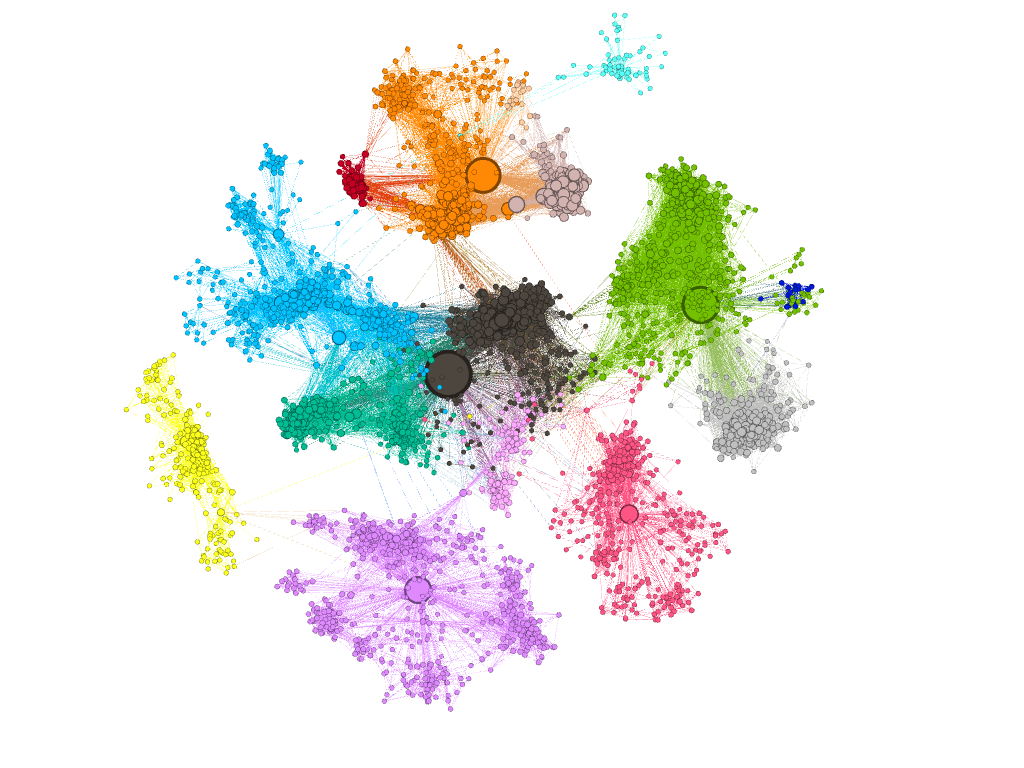

O objetivo desta abordagem "explodida" é destacar a escala e a complexidade das conexões que estruturam a rede, antes de focar nos agrupamentos densos. A partir desta visualização, é possível extrair as seguintes conclusões:

* **Conexões de Longo Alcance:** As longas linhas (arestas) que atravessam o grafo demonstram que nós em regiões visualmente distantes podem estar diretamente conectados. Isso é característico de redes "small-world", facilitando o fluxo rápido de informação através de todo o sistema.

* **Papel dos Hubs Centrais:** Os nós maiores, cujo tamanho foi mapeado para o grau (*Degree*), destacam-se como hubs de alta conectividade. Nota-se a presença de um nó central particularmente grande (em cinza escuro) que atua como uma "ponte global", com conexões se irradiando para diversas regiões coloridas, o que é uma representação visual de um alto betweenness.

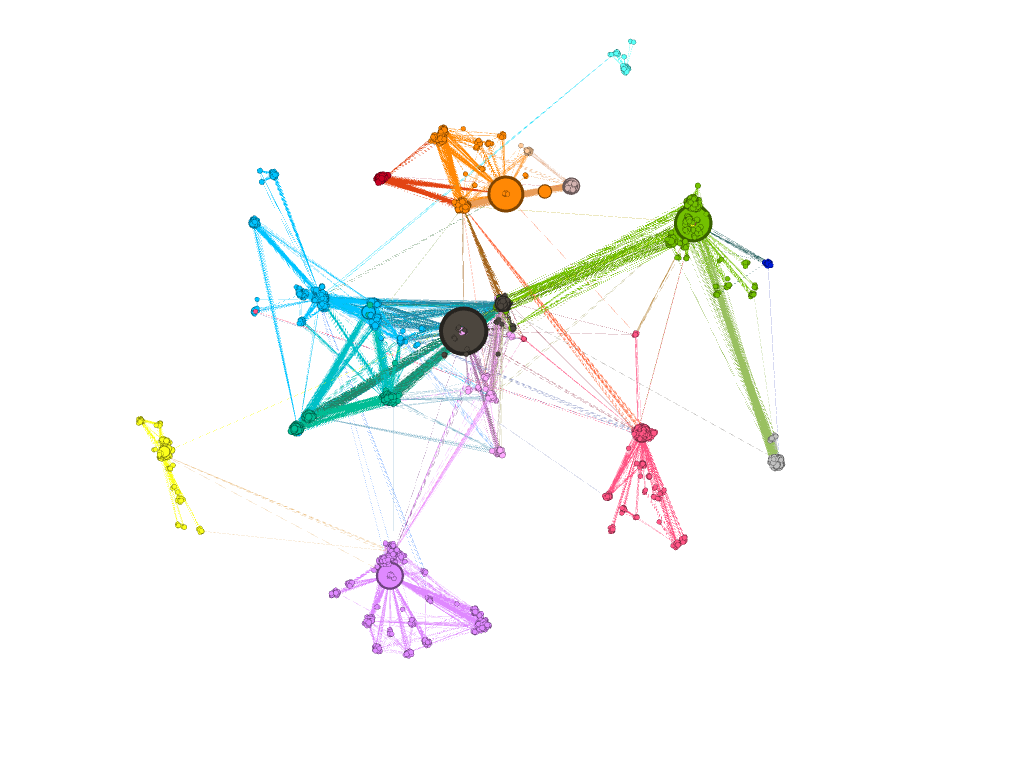

Na imagem acima os nós se agrupem de forma mais compacta. Esta abordagem é ideal para analisar a estrutura das comunidades, e dela podemos concluir:

* **Validação Visual da Modularidade:** A imagem confirma de maneira clara e intuitiva o alto score de modularidade (0.835) obtido pelo algoritmo Louvain. Os diferentes "continentes" de cores estão densos, bem definidos e com poucas arestas cruzando entre eles, que é a definição visual de uma excelente partição comunitária.

* **Identificação de Comunidades Centrais e Periféricas:** É possível observar que algumas comunidades, como a cinza escura no centro e a verde à direita, atuam como núcleos centrais da rede, possuindo conexões com múltiplos outros grupos. Outras, como a amarela (à esquerda) e a ciano claro (no topo), são mais periféricas, conectando-se de forma mais restrita ao restante da rede.

* **Estrutura Interna dos Grupos:** Dentro de cada cor, a presença de nós maiores (hubs locais) é evidente. Eles formam o centro de seus respectivos círculos sociais. A densidade de conexões ao redor desses hubs mostra como a informação e a influência se difundem dentro de cada comunidade.

---

# **7. Próximos Passos**

Este estudo cumpriu com sucesso seu objetivo de aplicar e validar um método de detecção de comunidades para identificar a macroestrutura de uma rede social. A análise revelou que o algoritmo Louvain é altamente eficaz em encontrar grandes e densas comunidades, conforme validado por métricas quantitativas (NMI) e pela inspeção visual.

No entanto, a etapa de validação também revelou uma oportunidade clara para a continuação deste trabalho. Observou-se uma diferença de **granularidade** entre o resultado do algoritmo (16 comunidades grandes) e o gabarito (centenas de círculos sociais menores e mais específicos).

Como próximos passos, o estudo será aprofundado com a aplicação de algoritmos que permitam um maior nível de granularidade, com o objetivo de gerar uma partição que se aproxime ainda mais da estrutura real dos círculos sociais.

---